<a href="https://colab.research.google.com/github/ghosh-sarbajit/AboutNLP/blob/main/PrivacyMeter/hf_causal_language_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auditing a Causal Language Model (LM) using the Population Attack

[Citation](https://github.com/privacytrustlab/ml_privacy_meter/blob/master/advanced/hf_causal_language_models.ipynb)

## Imports

In [1]:
import sys
import numpy as np
import torch
from typing import List, Tuple

In [2]:
!{sys.executable} -m pip install datasets
!{sys.executable} -m pip install transformers
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from IPython.display import clear_output
clear_output()

In [3]:
!pip install privacy-meter
!pip install opacus
from IPython.display import clear_output
clear_output()

In [4]:
# !{sys.executable} -m pip install -e ../.
from privacy_meter.audit import Audit
from privacy_meter.dataset import Dataset
from privacy_meter.hypothesis_test import threshold_func
from privacy_meter.information_source import InformationSource
from privacy_meter.information_source_signal import Signal
from privacy_meter.model import Model
from privacy_meter.metric import PopulationMetric
from privacy_meter.constants import InferenceGame
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport

## Hyperparameters

In [5]:
# a toy example for the population metric
num_train_seqs = 25
num_test_seqs = 25
num_population_seqs = 100
fpr_tolerance_list = [0.0, 0.1, 0.5, 0.9, 1.0]

## Load dataset and model using HuggingFace

### Load and split dataset

In [6]:
# download dataset from huggingface
hf_dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# remove empty rows
hf_dataset = hf_dataset.filter(lambda elem: len(elem["text"]) > 0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3760 [00:00<?, ? examples/s]

### Load and finetune model

In [7]:
# load pretrained and tokenizer
model_id = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model_obj = AutoModelForCausalLM.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

We tokenize and group the dataset before finetuning the model:

In [8]:
def tokenize_fn(examples):
    return tokenizer(examples["text"])

tokenized_hf_dataset = hf_dataset.map(
    tokenize_fn, batched=True, num_proc=2, remove_columns=["text"]
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/2891 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/23767 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2461 [00:00<?, ? examples/s]

In [9]:
block_size = 128
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    total_length = (total_length // block_size) * block_size

    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }

    result["labels"] = result["input_ids"].copy()
    return result

lm_hf_dataset = tokenized_hf_dataset.map(
    group_texts, batched=True, batch_size=64, num_proc=2
)

Map (num_proc=2):   0%|          | 0/2891 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/23767 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2461 [00:00<?, ? examples/s]

In [10]:
finetune_args = TrainingArguments(num_train_epochs=5, output_dir="privacy_meter_logs/")

In [11]:
hf_trainer = Trainer(
    model=model_obj,
    args=finetune_args,
    train_dataset=lm_hf_dataset["train"].select(range(num_train_seqs)),
    eval_dataset=lm_hf_dataset["validation"]
)

hf_trainer.train()

Step,Training Loss


TrainOutput(global_step=20, training_loss=3.8229156494140626, metrics={'train_runtime': 270.9505, 'train_samples_per_second': 0.461, 'train_steps_per_second': 0.074, 'total_flos': 4082761728000.0, 'train_loss': 3.8229156494140626, 'epoch': 5.0})

## Extend Privacy Meter to work with HuggingFace Causal LMs

### Extend the Model class

In [12]:
class HfCausalLMModel(Model):
    """Inherits of the Model class, an interface to query a model without any assumption on how it is implemented.
    This particular class is to be used with HuggingFace Causal LM models.
    """

    def __init__(self, model_obj, loss_fn, stride=64):
        """Constructor
        Args:
            model_obj: model object
            loss_fn: loss function
            stride: window size that will be used by the fixed length
            causal model for processing an input sequence
        """

        # Initializes the parent model
        super().__init__(model_obj, loss_fn)

        self.stride = stride

    def get_outputs(self, batch_samples):
        """Function to get the model output from a given input.
        Args:
            batch_samples: Model input
        Returns:
            Model output
        """
        pass

    def get_loss(self, batch_samples, batch_labels):
        """Function to get the model loss on a given input and an expected output.
        Args:
            batch_samples: Model input
            batch_labels: Model expected output
        Returns:
            The loss value, as defined by the loss_fn attribute.
        """
        pass

    def get_logits(self, batch_samples):
        return super().get_logits(batch_samples)
    def get_grad(self, batch_samples, batch_labels):
        """Function to get the gradient of the model loss with respect to the model parameters, on a given input and an
        expected output.
        Args:
            batch_samples: Model input
            batch_labels: Model expected output
        Returns:
            A list of gradients of the model loss (one item per layer) with respect to the model parameters.
        """
        pass

    def get_intermediate_outputs(self, layers, batch_samples, forward_pass=True):
        """Function to get the intermediate output of layers (a.k.a. features), on a given input.
        Args:
            layers: List of integers and/or strings, indicating which layers values should be returned
            batch_samples: Model input
            forward_pass: Boolean indicating if a new forward pass should be executed. If True, then a forward pass is
                executed on batch_samples. Else, the result is the one of the last forward pass.
        Returns:
            A list of intermediate outputs of layers.
        """
        pass

    def get_perplexity(self, batch_samples):
        """Function to get the perplexity of the model loss, on a given input sequence.
        Args:
            batch_samples: Model input
        Returns:
            A list of perplexity values.
        """
        max_length = self.model_obj.config.n_positions

        ppl_values = []
        for sample in batch_samples:
            sample_length = len(sample)

            sample = np.expand_dims(sample, axis=0) # the model takes in a batch of sequences
            sample = torch.tensor(sample, dtype=torch.long)

            nlls = []
            for i in range(0, sample_length, self.stride):
                begin_loc = max(i + self.stride - max_length, 0)
                end_loc = min(i + self.stride, sample_length)

                trg_len = end_loc - i  # may be different from stride on last loop

                input_ids = sample[:, begin_loc:end_loc]
                target_ids = input_ids.clone()
                target_ids[:, :-trg_len] = -100

                with torch.no_grad():
                    outputs = self.model_obj(input_ids, labels=target_ids)
                    neg_log_likelihood = outputs[0] * trg_len

                nlls.append(neg_log_likelihood)
            ppl = torch.exp(torch.stack(nlls).sum() / end_loc)

            ppl_values.append(ppl)

        return ppl_values

In [13]:
!pip install torchviz
from IPython.display import clear_output
clear_output()

In [38]:
# from torchviz import make_dot
# from IPython.display import Image, SVG, display

# dot = make_dot(outputs, params=dict(model.named_parameters()))
# dot.format = 'svg'
# # dot.render('WordWindowClassifier')
# dot.render("word_window_classifier")
# # display(Image("WordWindowClassifier.jpg"))
# display(SVG("word_window_classifier.svg"))

### Create a new Signal for computing perplexity

In [29]:
class ModelPerplexity(Signal):
    """
    Inherits of the Signal class, used to represent any type of signal that can be obtained from a Model and/or a Dataset.
    This particular class is used to get the perplexity of a model.
    """

    def __call__(self,
                 models: List[Model],
                 datasets: List[Dataset],
                 model_to_split_mapping: List[Tuple[int, str, str, str]],
                 extra: dict
                 ):
        """Built-in call method.
        Args:
            models: List of models that can be queried.
            datasets: List of datasets that can be queried.
            model_to_split_mapping: List of tuples, indicating how each model should query the dataset.
                More specifically, for model #i:
                model_to_split_mapping[i][0] contains the index of the dataset in the list,
                model_to_split_mapping[i][1] contains the name of the split,
                model_to_split_mapping[i][2] contains the name of the input feature,
                model_to_split_mapping[i][3] contains the name of the output feature.
                This can also be provided once and for all at the instantiation of InformationSource, through the
                default_model_to_split_mapping argument.
            extra: Dictionary containing any additional parameter that should be passed to the signal object.
        Returns:
            The signal value.
        """

        results = []
        # Compute the signal for each model
        for k, model in enumerate(models):
            # Extract the features to be used
            dataset_index, split_name, input_feature, output_feature = model_to_split_mapping[k]
            x = datasets[dataset_index].get_feature(split_name, input_feature)
            # Compute the signal
            results.append(model.get_perplexity(x))
        return results

### Audit LM using PopulationMetric

We first create the target and reference datasets using the `Dataset` class. Since we already processed the dataset before for finetuning, we do not need to pass a preprocessing function while creating the `Dataset` objects:

In [30]:
# split data into 'train', 'test', and 'population'
train_split = lm_hf_dataset["train"].select(range(num_train_seqs))
test_split =  lm_hf_dataset["test"].select(range(num_test_seqs))
population_split = lm_hf_dataset["train"].select(
    range(num_train_seqs, (num_train_seqs + num_population_seqs))
)

In [31]:
# set format of datasets to be compatible with Privacy Meter
train_split.set_format("numpy")
test_split.set_format("numpy")
population_split.set_format("numpy")

In [32]:
train_ds = {'input': train_split['input_ids']}
test_ds = {'input': test_split['input_ids']}
population_ds = {'input': population_split['input_ids']}

In [33]:
target_dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='input',
    default_output=None
)

In [34]:
reference_dataset = Dataset(
    data_dict={'train': population_ds},
    default_input='input',
    default_output=None
)

Then, we wrap the model we finetuned into our custom `HfCausalLMModel` class:

In [35]:
stride = 512
model_obj.to('cpu')
target_model = HfCausalLMModel(
    model_obj=model_obj,
    loss_fn=None,
    stride=stride
)

Next, we create the target and reference `InformationSource` objects for the audit:

In [36]:
target_info_source = InformationSource(
    models=[target_model],
    datasets=[target_dataset]
)

reference_info_source = InformationSource(
    models=[target_model],
    datasets=[reference_dataset]
)

And now we create a `PopulationMetric` object that uses perplexity as the signal:

In [37]:
population_metric_obj = PopulationMetric(
    target_info_source=target_info_source,
    reference_info_source=reference_info_source,
    signals=[ModelPerplexity()],
    hypothesis_test_func=threshold_func,
)

Finally, we create the `Audit` object and run the audit on our finetuned model:

In [25]:
audit_obj = Audit(
    metrics=population_metric_obj,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL
)
audit_obj.prepare()

audit_results = audit_obj.run()
for result in audit_results:
    print(result)

Results are stored in: ['/content/log_2024-09-04_12-15-51-000']


In [26]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

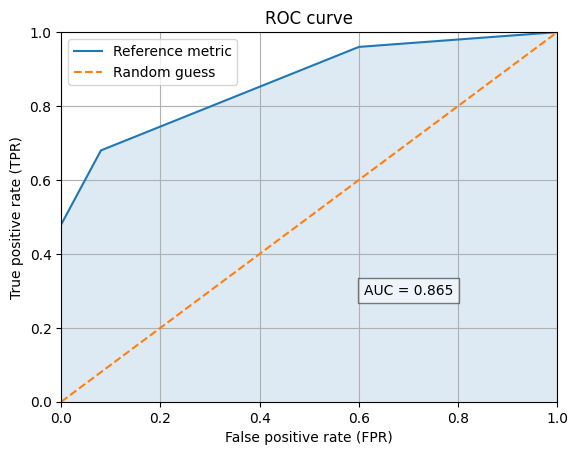

AUC = 0.865


<Figure size 640x480 with 0 Axes>

In [27]:
ROCCurveReport.generate_report(
    metric_result=audit_results[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

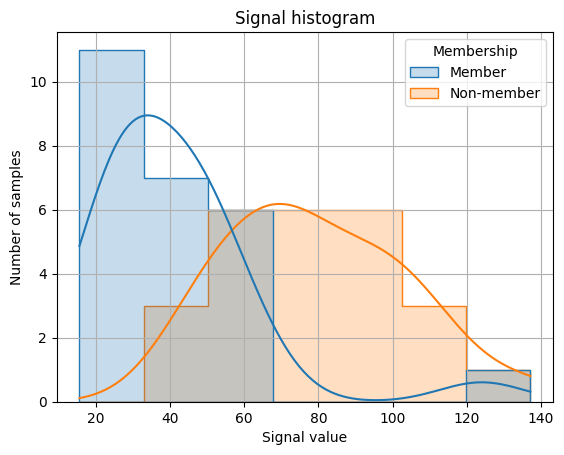

<Figure size 640x480 with 0 Axes>

In [28]:
SignalHistogramReport.generate_report(
    metric_result=audit_results[0][0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)